In [1]:
from pathlib import Path

from joblib import Memory
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [2]:
DATA_DIR = Path.cwd() / 'data/' # EMG signals
CACHE_DIR = Path.cwd() / 'cache/' # cache previously done computations (via joblib)

memory = Memory(CACHE_DIR)

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a

def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y

@memory.cache
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out


In [4]:
def loadmat(filename):
    file = h5py.File(filename, 'r')
    return np.asarray(file['grid_crds']), np.asarray(file['out_mat'])

if1_grid_crds, if1_out_mat = loadmat(DATA_DIR / r'increasing-force-1.mat')
if2_grid_crds, if2_out_mat = loadmat(DATA_DIR / r'increasing-force-2.mat')
sf1_grid_crds, sf1_out_mat = loadmat(DATA_DIR / r'steady-force-1.mat')

emg = if1_out_mat

In [5]:
print(emg.shape)

(60160, 64)


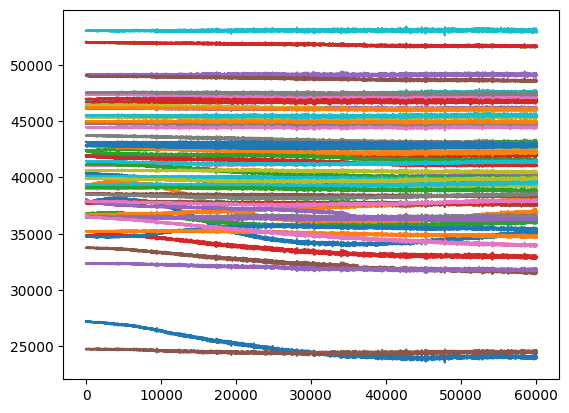

In [6]:
plt.plot(emg)
plt.show()

In [7]:
filtered_if1_out_mat = filt_GRID(emg.T).T

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-2236319871.filt_GRID...
filt_GRID(array([[37753.414062, ..., 35028.390625],
       ...,
       [52030.175781, ..., 51611.378906]]))
________________________________________________________filt_GRID - 0.3s, 0.0min


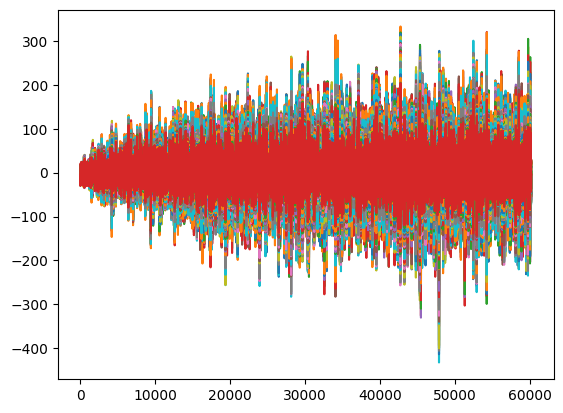

In [8]:
plt.plot(filtered_if1_out_mat)
plt.show()

In [9]:
fastica = FastICA(n_components=filtered_if1_out_mat.shape[1])
ica_fit = memory.cache(fastica.fit)

In [10]:
fastica_model = ica_fit(filtered_if1_out_mat)
IC = fastica_model.transform(filtered_if1_out_mat)
print(IC)

________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.FastICA.fit...
fit(array([[-3.786416, ..., -6.213112],
       ...,
       [-3.090597, ..., -3.784546]]))


/home/faerryn/mlsp-project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


_____________________________________________________________fit - 23.7s, 0.4min
[[ 0.2056802   0.05403525 -0.5123971  ... -0.02832402 -0.19653965
  -0.0818984 ]
 [-0.07644441  0.3624015  -0.43463435 ... -0.19256352 -0.55573271
  -0.03464607]
 [-0.3181176   0.61819278 -0.4736462  ... -0.41328081 -0.93156148
  -0.0460144 ]
 ...
 [ 0.66137211 -0.60742453  0.50036611 ...  0.53946722 -0.04796153
  -0.24103525]
 [ 0.34699294 -0.5580289   0.24133906 ...  0.41581048 -0.00575279
  -0.1532612 ]
 [ 0.01394499 -0.20587416  0.01796992 ...  0.03516981  0.24109768
  -0.02042009]]


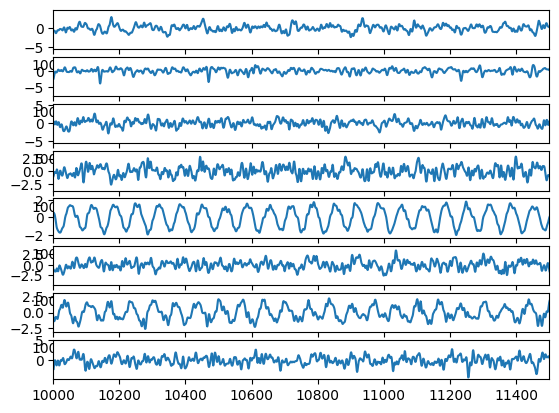

In [11]:
fig, ax = plt.subplots(nrows=IC.shape[1]//8)
for i in range(0, IC.shape[1]//8):
    ax[i].plot(IC[:, i])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()

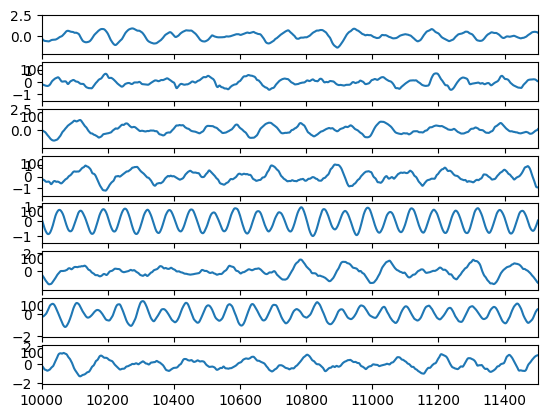

In [19]:
filtered_IC = savgol_filter(IC, 64, 2, axis=0)

fig, ax = plt.subplots(nrows=filtered_IC.shape[1]//8)
for i in range(0, filtered_IC.shape[1]//8):
    ax[i].plot(filtered_IC[:, i])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()